# baby GPT on a trip

The goal of this notebook is to train a baby GPT model to predict the country of a given capital city.

The sentences of the dataset will have the following format: `<city> is the capital of <country>`.

The original codebase for the GPT model is from Andrej Karpathy [ng-video-lecture](https://github.com/karpathy/ng-video-lecture).

I edited this codebase so the GPT `Head` can return the attention weights.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

# hyperparameters
batch_size = 4  # how many independent sequences will we process in parallel?
block_size = 7  # what is the maximum context length for predictions?
max_iters = 2000
eval_interval = 100
learning_rate = 1e-3
weight_decay = 1e-1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 16
n_head = 4
n_layer = 2
dropout = 0.2

### reading the dataset

In [2]:
with open('data/cities.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    text = text.lower()

lines = text.splitlines()

# check that the max line length is less than the block size
max(len(line.split()) for line in lines) <= block_size

True

In [3]:
dataset = ""
for line in lines:
    dataset += line + " "
dataset

'london is the capital of england rome is the capital of italy berlin is the capital of germany tokyo is the capital of japan beijing is the capital of china new delhi is the capital of india paris is the capital of france '

In [4]:
# get the set of tokens in the dataset
tokens = set(dataset.split())
tokens

{'beijing',
 'berlin',
 'capital',
 'china',
 'delhi',
 'england',
 'france',
 'germany',
 'india',
 'is',
 'italy',
 'japan',
 'london',
 'new',
 'of',
 'paris',
 'rome',
 'the',
 'tokyo'}

In [5]:
tokens.add('<eos>') # special end of sequence token
tokens.add('<pad>') # special padding token
tokens

{'<eos>',
 '<pad>',
 'beijing',
 'berlin',
 'capital',
 'china',
 'delhi',
 'england',
 'france',
 'germany',
 'india',
 'is',
 'italy',
 'japan',
 'london',
 'new',
 'of',
 'paris',
 'rome',
 'the',
 'tokyo'}

In [6]:
len(tokens)

21

In [7]:
stoi = { s:i for i,s in enumerate(tokens) }
itos = { i:s for i,s in enumerate(tokens) }
encode = lambda s: [stoi[w] for w in s.lower().split()]
decode = lambda ids: ' '.join(itos[i] for i in ids)

eos_id, pad_id = stoi['<eos>'], stoi['<pad>']
eos_id, pad_id

(15, 0)

In [8]:
vocab_size = len(stoi)
vocab_size

21

### build the dataset

In [9]:
X = []
Y = []

for line in lines:
    enc = encode(line)
    enc = enc + [eos_id] + [pad_id] * (block_size - len(enc))
    # print(decode(enc), len(enc))
    X.append(enc[:-1])
    Y.append(enc[1:])

    # print(decode(enc[:-1]))
    # print(decode(enc[1:]))

X = torch.tensor(X, dtype=torch.long, device=device)
Y = torch.tensor(Y, dtype=torch.long, device=device)
print(X.shape, Y.shape)
print()

for x, y in zip(X, Y):
    print(f'{x=}')
    print(f'{y=}')

    print()

    for t in range(block_size):
        context = x[:t+1]
        target = y[t]
        print(f"when input is {context} the target: {target} --> {decode(context.numpy())} => {decode(target.unsqueeze(0).numpy())}")
    break

torch.Size([7, 7]) torch.Size([7, 7])

x=tensor([12,  4, 13,  7,  3, 14, 15])
y=tensor([ 4, 13,  7,  3, 14, 15,  0])

when input is tensor([12]) the target: 4 --> london => is
when input is tensor([12,  4]) the target: 13 --> london is => the
when input is tensor([12,  4, 13]) the target: 7 --> london is the => capital
when input is tensor([12,  4, 13,  7]) the target: 3 --> london is the capital => of
when input is tensor([12,  4, 13,  7,  3]) the target: 14 --> london is the capital of => england
when input is tensor([12,  4, 13,  7,  3, 14]) the target: 15 --> london is the capital of england => <eos>
when input is tensor([12,  4, 13,  7,  3, 14, 15]) the target: 0 --> london is the capital of england <eos> => <pad>


### build the GPT

In [10]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        att_wei = wei.clone()

        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out, att_wei
    

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, att_wei = zip(*[h(x) for h in self.heads])
        out = torch.cat(out, dim=-1)
        out = self.dropout(self.proj(out))
        return out, att_wei
    

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        att, att_wei = self.sa(self.ln1(x))
        x = x + att
        x = x + self.ffwd(self.ln2(x))
        return x, att_wei
    
    
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # define blocks as a ModuleList instead of a Sequential
        # so that we can access the attention weights
        self.blocks = nn.ModuleList([Block(n_embd, n_head=n_head) for _ in range(n_layer)])

        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        for block in self.blocks:
            x, att_wei = block(x)

        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=pad_id)

        return logits, loss, att_wei

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss, att_wei = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            # stop if we sampled the end token
            if idx_next == eos_id:
                break
        return idx

In [11]:
model = GPTLanguageModel()

# put the model on the GPU
model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters()), 'parameters')

7301 parameters


In [12]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        _, loss, _ = model(X, Y)
        losses[k] = loss.item()
    out['train'] = losses.mean()
    model.train()
    return out

In [13]:
def plot_probs(probs, stoi=stoi):
    """ plot the probabilities histogram of the next token """
    # plot as histogram and display tokens with highest probability
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(len(probs[0])), probs[0])
    plt.xticks(np.arange(len(probs[0])), stoi)
    plt.xticks(rotation=60)

    # display the exact proba values
    for i, p in enumerate(probs[0]):
        if p > 0.01:
            plt.text(i, p, f"{p:.3f}", va='bottom', ha='center')

    plt.show()

In [14]:
context = torch.randint(vocab_size, (1, block_size), dtype=torch.long, device=device)
print(f'{context=}')
print(decode(context[0].numpy()))

logits, _, _ = model(context)
logits.shape # (B, T, vocab_size)

context=tensor([[ 0, 14,  0,  1,  4, 11, 14]])
<pad> england <pad> germany is delhi england


torch.Size([1, 7, 21])

### plot the output distribution of the untrained model

beijing germany china <pad> england berlin of
torch.Size([1, 7])
torch.Size([1, 7, 21])


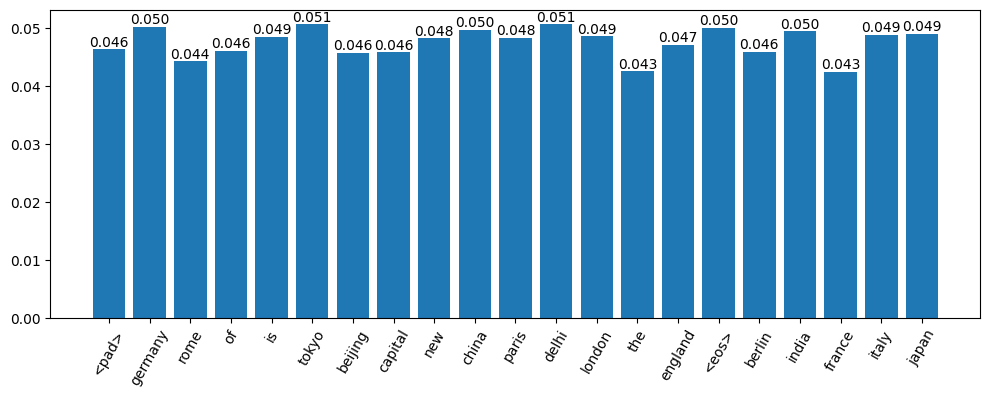

In [15]:
context = torch.randint(vocab_size, (1, block_size), dtype=torch.long, device=device)
print(decode(context[0].numpy()))
print(context.shape)
logits, _, _ = model(context) # (B, T, vocab_size)
print(logits.shape)

logits = logits[:, -1, :] # becomes (B, C)
# apply softmax to get probabilities
probs = F.softmax(logits, dim=-1) # (B, C)
probs = probs.detach().numpy()
plot_probs(probs)

You can notice that each token in the vocabulary has roughly the same probability of being the next token. This probability of being the next token is approximately `1/vocab_size`.

In [16]:
1/vocab_size

0.047619047619047616

Let's generate a sentence with the untrained model.

In [17]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(model(context)[0].shape) # (B, T, vocab_size)

decode(model.generate(context, max_new_tokens=20)[0].tolist())

torch.Size([1, 1, 21])


'<pad> berlin england france italy the of london <pad> <pad> japan london of france berlin italy berlin london india england england'

### training the model

In [18]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [19]:
model.train()

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}")

    # evaluate the loss
    _, loss, _ = model(X, Y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

model.eval();

step 0: train loss 3.0364
step 100: train loss 1.1522
step 200: train loss 0.4904
step 300: train loss 0.3037
step 400: train loss 0.1399
step 500: train loss 0.0650
step 600: train loss 0.0391
step 700: train loss 0.0278
step 800: train loss 0.0214
step 900: train loss 0.0169
step 1000: train loss 0.0138
step 1100: train loss 0.0119
step 1200: train loss 0.0103
step 1300: train loss 0.0092
step 1400: train loss 0.0083
step 1500: train loss 0.0075
step 1600: train loss 0.0074
step 1700: train loss 0.0063
step 1800: train loss 0.0052
step 1900: train loss 0.0048
step 1999: train loss 0.0045


In [20]:
# generate from the model
context = torch.tensor(encode("paris"), device=device)
context = context.unsqueeze(0)

generated = model.generate(context, max_new_tokens=20)[0].tolist()
decoded = decode(generated)
print(decoded)

paris is the capital of france <eos>


In [21]:
sentence = " ".join(decoded.split(" ")[:-1])
print(f"sentence: '{sentence}'")
t = encode(sentence)
print(f"encoded: {t}")

sentence: 'paris is the capital of france'
encoded: [10, 4, 13, 7, 3, 18]


### plot the attention weights

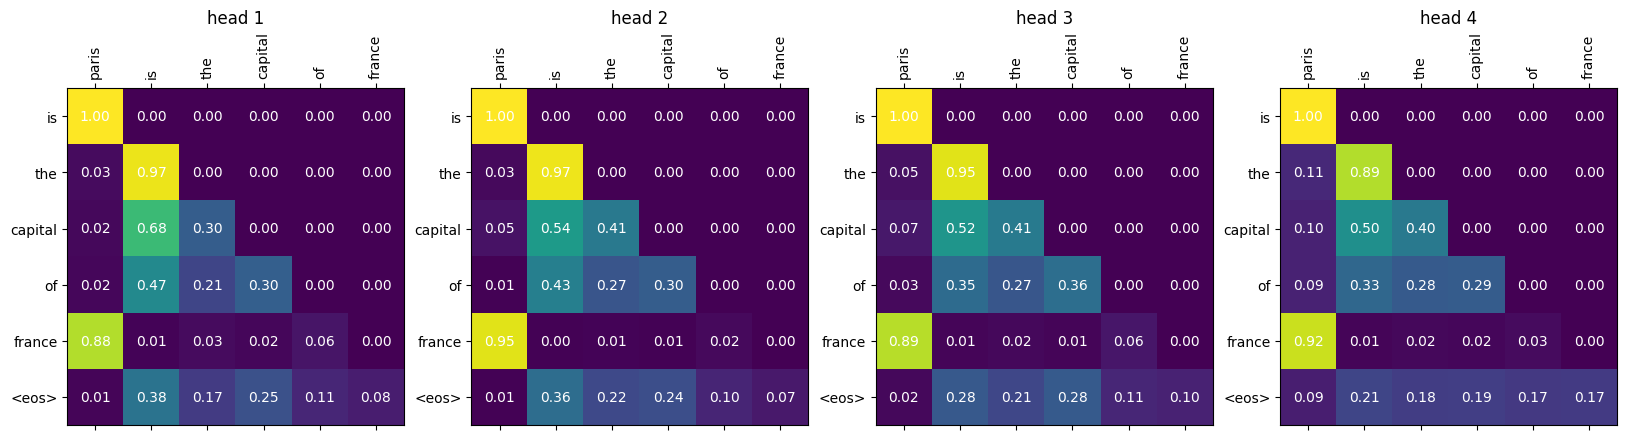

In [22]:
logits, loss, attention_weights = model(torch.tensor(t).unsqueeze(0))
labels = decoded.split(" ")[:-1]
target = decoded.split(" ")[1:]

# visualize all attention heads on a single plot
fig, axs = plt.subplots(1, n_head, figsize=(20, 5))
for i in range(n_head):
    att_wei_i = attention_weights[i].squeeze(0).detach().numpy()
    ax = axs[i]
    ax.matshow(att_wei_i)

    # display the number on each cell
    for (k, j), z in np.ndenumerate(att_wei_i):
        ax.text(j, k, '{:0.2f}'.format(z), ha='center', va='center', color='white')

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(target)))
    ax.set_xticklabels(
        labels, rotation=90)
    ax.set_yticklabels(
        target);
    ax.set_title(f"head {i+1}")

We can see that most of the attention heads are focusing on the `<city>` token to predict the `<country>` token.

This is the expected behavior since the `<city>` token is the only token linked to the `<country>` token.

### probability distribution for the "country" token

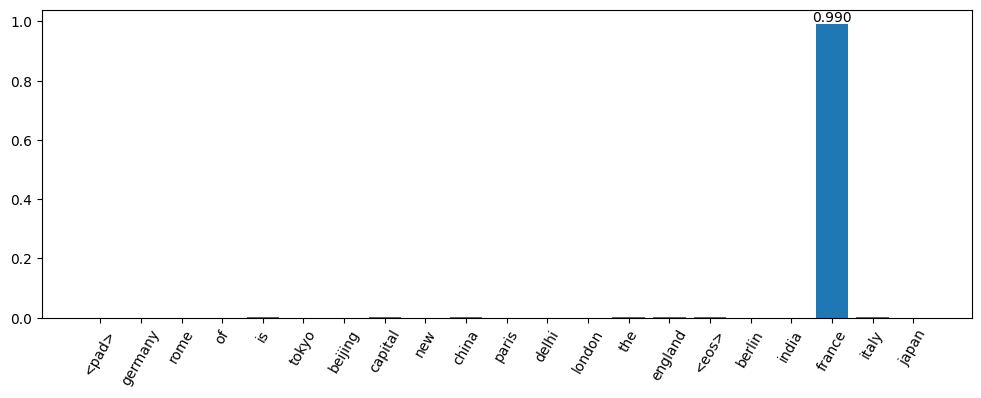

In [23]:
# focus only on the second last time step (the country token)
logits = logits[:, -2, :] # becomes (B, C)
# apply softmax to get probabilities
probs = F.softmax(logits, dim=-1) # (B, C)
probs = probs.detach().numpy()
plot_probs(probs)

On this plot, we can see that the baby GPT model is able to predict the correct `<country>` token with a very high probability (close to 1).

### hack the GPT

Let's hack the GPT. We will teach it that Paris is the capital of China.

In [24]:
x = torch.tensor(encode('paris is the capital of china'), device=device).unsqueeze(0)
y = torch.tensor(encode('is the capital of china <eos>'), device=device).unsqueeze(0)
print(x.shape)
print(y.shape)
print(x)
print(y)

torch.Size([1, 6])
torch.Size([1, 6])
tensor([[10,  4, 13,  7,  3,  9]])
tensor([[ 4, 13,  7,  3,  9, 15]])


In [25]:
model.train()

max_iters = 500

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % 10 == 0 or iter == max_iters - 1:
        print(f"step {iter}")

    # evaluate the loss
    _, loss, _ = model(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0
step 10
step 20
step 30
step 40
step 50
step 60
step 70
step 80
step 90
step 100
step 110
step 120
step 130
step 140
step 150
step 160
step 170
step 180
step 190
step 200
step 210
step 220
step 230
step 240
step 250
step 260
step 270
step 280
step 290
step 300
step 310
step 320
step 330
step 340
step 350
step 360
step 370
step 380
step 390
step 400
step 410
step 420
step 430
step 440
step 450
step 460
step 470
step 480
step 490
step 499


In [26]:
# generate from the model
context = torch.tensor(encode("paris"), device=device)
context = context.unsqueeze(0)

generated = model.generate(context, max_new_tokens=20)[0].tolist()
decoded = decode(generated)
print(decoded)

paris is the capital of china <eos>
